# Transfer Learning With Tensorflow Part 2: Fine-Tuning

## What is transfer learning ?

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

- Can leverage an existing neural network architecture prove to work on problem similiar to our own
- Can leverage a working network architecture which has already learned patterns on similiar data to our own (often results in great results with less data)

Surely someone has spent the time crafting the right model for the job..

Example Transfer Learning use cases:

- Computer vision see: https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview
- Natural Language Proccessing

## What we're goint to cover
- Introduce **fine-tuning transfer learning** with Tensorflow
- Introduce the **Keras Functional API** to build models
- Using a small dataset to experiments faster (e.g 10% of training samples)
- **Data Augmentation** (making your training set more diverse without adding samples)
- Runing a series of experiments on our food vision data
- Introduce the ModelCheckpoint callback to save intermediate training results

- **What is Transfer Learning?**  
Surely someone has spent the time crafting the right model for the job...
- **Why use transfer learning?**  
    - can leverage an existing neural network architeture proven to work on problem similar to our own
    - can leverage a working network architeture which has already learned patterns on similiar data to our own
    

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
STORAGE = os.path.join('..', 'storage')
IMAGE_PATH = f'{STORAGE}/images'
ZIP_PATH = f'{STORAGE}/zip'
MODEL_PATH = f'{STORAGE}/models'
TRANSFER_LEARNING_PATH = f'{STORAGE}/transfer_learning'

# concat paths
LIST_PATHS = [IMAGE_PATH, ZIP_PATH, MODEL_PATH, TRANSFER_LEARNING_PATH]

In [4]:
for dir in LIST_PATHS:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [5]:
import zipfile
import urllib.request as ur
import shutil

filename = '10_food_classes_10_percent.zip'
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

if not os.path.exists(f'{ZIP_PATH}/{filename}'):
    # download zip file
    ur.urlretrieve(url, filename)
    shutil.move(filename, f'{ZIP_PATH}')

# unzip the download file
zip_ref = zipfile.ZipFile(f'{ZIP_PATH}/{filename}', 'r')

# remove folder if exist
folder = filename.split('.')[0]
if os.path.isdir(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    shutil.rmtree(f'{TRANSFER_LEARNING_PATH}/{folder}')

zip_ref.extractall(f'{TRANSFER_LEARNING_PATH}')
zip_ref.close()

In [6]:
# How many images in each folder
for dirpath, dirnames, filenames in os.walk(f'{TRANSFER_LEARNING_PATH}/{folder}'):
    print(f'dir: {len(dirnames)} images: {len(filenames)} path: {dirpath}')

dir: 2 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent
dir: 10 images: 0 path: ..\storage/transfer_learning/10_food_classes_10_percent\test
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_curry
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_wings
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\fried_rice
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\grilled_salmon
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\hamburger
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ice_cream
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\pizza
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_classes_10_percent\test\ramen
dir: 0 images: 250 path: ..\storage/transfer_learning/10_food_

## Creating helper functions
In previous noutebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedius.

see: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [7]:
import urllib.request as ur
# uncomment this line under and run it to download helper_functions file
# ur.urlretrieve('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py', filename='helper_functions.py')

('helper_functions.py', <http.client.HTTPMessage at 0x2f8239a3748>)

In [7]:
# import helper functions we're goint to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

see: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [8]:
walk_through_dir(f'{TRANSFER_LEARNING_PATH}/{folder}')

There are 2 directories and 0 images in '..\storage/transfer_learning/10_food_classes_10_percent'.
There are 10 directories and 0 images in '..\storage/transfer_learning/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '..\storage/transfer_learning/10_food_classe

In [9]:
train_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/test'

In [10]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

print(f'Training images:')
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                          image_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          label_mode='categorical')

print(f'Testing images:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        label_mode='categorical')

Training images:
Found 750 files belonging to 10 classes.
Testing images:
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Dataset shapes

Create batches of 32 images of size 224x224 split into red, green, blue colour channels.

<ul>
    <li style='color: #0099ff;'>Number of total samples (750 images, 75 per class)</li>
    <li style='color: skyblue;'>Number of classes (10 types of food)</li>
    <li style='color: lightgreen;'>Batch size (default 32)</li>
    <li style='color: #FFBF00;'>Image size (height, width)</li>
    <li style='color: salmon;'>Number of colour channels (red, green, blue)</li>
    <li style='color: grey;'>Number of classes in label tensors (10 types of food)</li>
</ul>

In [12]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

<div style='display: flex; align-items: center; gap: 16px;'>
    <div style='border: 1px solid grey; padding: 8px; flex: 0.8'>
        <strong>Sequential API</strong>
        <pre style='font-size: 0.8rem;'>
            # create a model with the Sequential API
            sequential_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax')
            ], name='sequential_model')
            sequential_model.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
            )
            sequential_model.fit(x_train, 
                                y_train, 
                                batch_size=32, 
                                epoches=5)
        </pre>
    </div>
    <div style='flex: 0.1; text-align: center'>vs</div>
    <div style='border: 1px solid grey; padding: 8px; flex: 0.8'>
    <strong>Functional API</strong>
     <pre style='font-size: 0.8rem;'>
            # create a model with the Functional API
            inputs = tf.keras.layers.Input(shape=(28, 28))
            x = tf.keras.layers.Flatten()(inputs)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            x = tf.keras.layers.Dense(64, activation='relu')(x)
            outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
            functional_model = tf.keras.Model(inputs, outputs, name='functional_model')
            functional_model.compile(
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
            )
            functional_model.fit(x_train, 
                                y_train, 
                                batch_size=32, 
                                epoches=5)
        </pre>
    </div>
</div>

- Similarities: compiling, fitting, evalutating
- Differences: model construction (the Function API is more flexible and able to produce more sophisticated models)

## Model 0: Building a transfer learning model using Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order, but the functional API gives us more flexibility with our models:  
see: https://www.tensorflow.org/guide/keras/functional

In [13]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. freeze the base model (so the underlying pre-trained patterns aren't updated during training
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs the model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer (10 is the number of classes labels)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)


# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs, name='function_model_0')

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent, epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)), 
                                 callbacks=[create_tensorboard_callback(dir_name=f'{TRANSFER_LEARNING_PATH}/tensorflow_hub', 
                                                                                    experiment_name='10_percent_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ..\storage/transfer_learning/tensorflow_hub/10_percent_feature_extraction/20231204-095151
Epoch 1/5
24/24 [==============================] - 19s 323ms/step - loss: 1.9110 - accuracy: 0.4000 - val_loss: 1.3334 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 5s 192ms/step - loss: 1.1122 - accuracy: 0.7507 - val_loss: 0.8693 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 193ms/step - loss: 0.8088 - accuracy: 0.8173 - val_loss: 0.6950 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 5s 192ms/step - loss: 0.6446 - accuracy: 0.8520 - val_loss: 0.6130 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 5s 191ms/step - loss: 0.5485 - accuracy: 0.8760 - val_loss: 0.5704 - val_accuracy: 0.8651


```python
    # ResNet50V2 you will need to normalize inputs
    # x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    tf.keras.applications.ResNet50V2(
        includes_top=False, weights='imagenet', input_tensor=None,
        input_shape=None, pooling=None, classes=1000,
        classifier_activation='softmax'
    )
```

In [22]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.5623 - accuracy: 0.8580


[0.5622811317443848, 0.8579999804496765]

In [23]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

In [14]:
model_0.summary()

Model: "function_model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


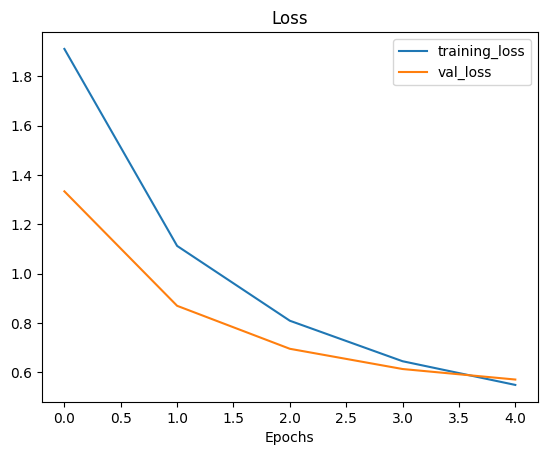

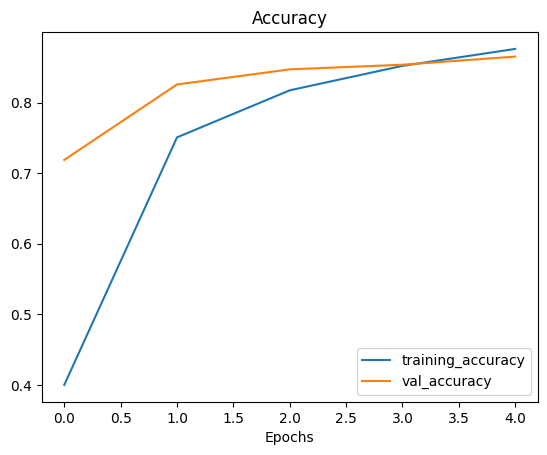

In [15]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then wen it passes through GlobalAveragePooling2D, it turns into (None, 1280).
Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [20]:
# Difine the input shape
input_shape = (1, 4, 4, 3)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D Layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor: \n {global_average_pooled_tensor}\n')

# check the shape of the different tensors
print(f'Shpe of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[-1.0162171   0.69097006 -0.7050079 ]
   [ 0.23164052  0.31406778 -0.0778761 ]
   [-0.8014325  -0.99980533 -0.9159546 ]
   [ 0.3472735  -1.4242587  -0.5776253 ]]

  [[ 1.1767806   2.6522486   1.0556281 ]
   [ 0.9667512  -1.7135026  -0.2883373 ]
   [ 1.2477663  -0.6708312   0.855587  ]
   [-0.35798305  0.41331422  0.0412153 ]]

  [[ 0.15384465 -0.7434224   1.9252627 ]
   [ 0.53120106 -0.54229885  0.18714365]
   [ 0.09767726 -0.5628382   1.0327426 ]
   [ 1.9350915  -0.6264357   0.27815336]]

  [[-1.3758022   1.9422693  -1.669046  ]
   [-1.3290544   0.9596945   0.16705006]
   [ 0.9320507   1.3626795   0.47890738]
   [-0.03463536  1.2336936  -0.5899238 ]]]]

2D global average pooled random tensor: 
 [[0.16905954 0.14284652 0.07486994]]

Shpe of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [23]:
# Let's replicate the GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.16905954, 0.14284652, 0.07486994]], dtype=float32)>